# Experimenting with NLP Tensorflow Hub modules
based on Final Project - YCBS258

#### Prepared by Jocelyn Prince (Jan 2020)
---

## Sentiment Analysis Project - Post to Medium
#### NLP with the following Module from Tensorflow Hub
* ELMO


### Description
Use some modules available in Tensorflow Hub to experiment NLP tasks.  Deploy a model on Google's AI-Platform (also called ML Engine) and demonstrate the model returning a prediction.

Details:
* Dataset for training: Sentiment140 (source: http://help.sentiment140.com/for-students/)

References:

* Prateek Joshi and his post: https://www.analyticsvidhya.com/blog/2019/03/learn-to-use-elmo-to-extract-features-from-text/

* https://arxiv.org/pdf/1802.05365.pdf

* https://colab.research.google.com/github/tensorflow/hub/blob/master/examples/colab/tf2_text_classification.ipynb#scrollTo=Eg62Pmz3o83v

* Aurélien Géron’s Book: hands-on Machine Learning with Scikit-Learn, Keras and Tensorflow, O’Reilly Media Inc.
-----

In [1]:
import tensorflow as tf
assert tf.__version__ >= "1.15"

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


# Import Libraries

In [0]:
# This Notebook needs to be executed under Python ≥3.5 and TensorFlow >= 2.0
import sys
assert sys.version_info >= (3, 5)
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras import optimizers
import tensorflow_hub as hub
assert tf.__version__ >= "1.15"

# Minimum Requirement for Scikit-Learn ≥0.20 is required
#import sklearn
#assert sklearn.__version__ >= "0.20"

if not tf.test.is_gpu_available():
    print("No GPU was detected. This code can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")

# Common imports
import time
import pandas as pd
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(20)

In [5]:
tf.__version__

'1.15.0'

In [6]:
import tensorflow as tf
tf.test.is_gpu_available()

True

In [7]:
# The spacy module needs to be installed
!pip install spacy

# The english module needs to be downloaded if not already
!python3 -m spacy download en

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Linking successful
/usr/local/lib/python3.6/dist-packages/en_core_web_sm -->
/usr/local/lib/python3.6/dist-packages/spacy/data/en
You can now load the model via spacy.load('en')


In [0]:
# Import other common libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, classification_report
import itertools
import re
import spacy

In [0]:
# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

# Where to save the figures
PROJECT_ROOT_DIR = "."
FOLDER= "rnn"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", FOLDER)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Import Dataset: Sentiment140 Tweets


In [0]:
trainfile = "/content/drive/My Drive/Colab Notebooks/Final_Project/data/training.1600000.processed.noemoticon.csv"
testfile = "/content/drive/My Drive/Colab Notebooks/Final_Project/data/testdata.manual.2009.06.14.csv"
columns = ['polarity','id','date','query_string','twitter_user','tweet']

In [11]:
# Import Train data set
df_train = pd.read_csv(trainfile,
                 header=None, 
                 names=columns, 
                 encoding='latin-1')
df_train.shape

(1600000, 6)

In [12]:
# Import Test data set
df_test = pd.read_csv(testfile,
                 header=None, 
                 names=columns, 
                 encoding='latin-1')
df_test.shape

(498, 6)

# Data Preprocessing

## Explore Data

In [0]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
polarity        1600000 non-null int64
id              1600000 non-null int64
date            1600000 non-null object
query_string    1600000 non-null object
twitter_user    1600000 non-null object
tweet           1600000 non-null object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


In [0]:
df_train.tweet[0:10]

0    @switchfoot http://twitpic.com/2y1zl - Awww, t...
1    is upset that he can't update his Facebook by ...
2    @Kenichan I dived many times for the ball. Man...
3      my whole body feels itchy and like its on fire 
4    @nationwideclass no, it's not behaving at all....
5                        @Kwesidei not the whole crew 
6                                          Need a hug 
7    @LOLTrish hey  long time no see! Yes.. Rains a...
8                 @Tatiana_K nope they didn't have it 
9                            @twittera que me muera ? 
Name: tweet, dtype: object

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f4d2cf7deb8>]],
      dtype=object)

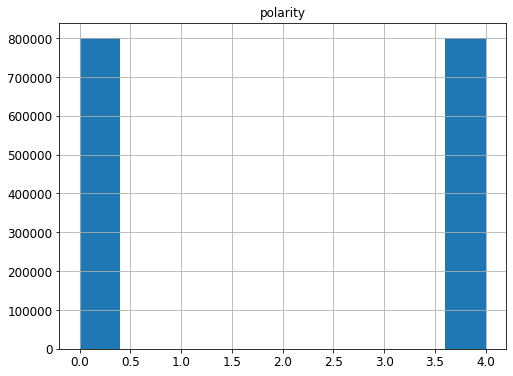

In [0]:
df_train.hist(["polarity"])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f4d2ce8e278>]],
      dtype=object)

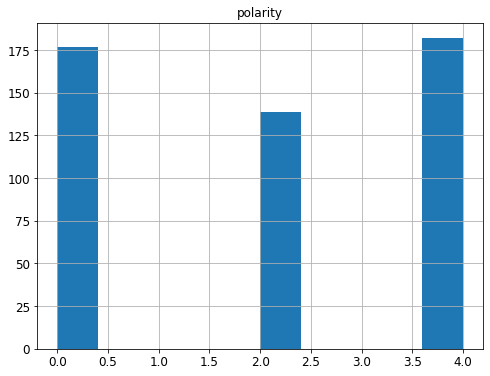

In [0]:
df_test.hist(["polarity"])

## Split Train and Test dataset


In [0]:
NUMTRAIN = 150000
NUMTEST = 3000
train_set = df_train[['id','polarity', 'tweet']].sample(NUMTRAIN)
test_set = df_train[['id','polarity', 'tweet']].sample(NUMTEST)

In [0]:
X_train = train_set.drop("polarity", axis=1) # drop labels for training set
y_train = train_set["polarity"].copy()

In [0]:
X_test = test_set.drop("polarity", axis=1) # drop labels for test set
y_test = test_set["polarity"].copy()

In [16]:
print("X_train: " + str(X_train.shape) + str(type(X_train)))
print("y_train: "+ str(y_train.shape)+ str(type(y_train)))
print("X_test: " + str(X_test.shape) + str(type(X_test)))
print("y_test: "+ str(y_test.shape)+ str(type(y_test)))

X_train: (150000, 2)<class 'pandas.core.frame.DataFrame'>
y_train: (150000,)<class 'pandas.core.series.Series'>
X_test: (3000, 2)<class 'pandas.core.frame.DataFrame'>
y_test: (3000,)<class 'pandas.core.series.Series'>


In [0]:
y_train.head()


313228     0
253601     0
1041037    4
217422     0
495067     0
Name: polarity, dtype: int64

## Functions : Text-preprocessing and Lemmatize (Normalize) Tweets

In [0]:
def text_processing(tweet, preprocess=True):
    # remove https links
    clean_tweet = re.sub(r'http\S+', '', tweet)
    # remove punctuation marks
    punctuation = '!"#$%&()*+-/:;<=>?@[\\]^_`{|}~'
    clean_tweet = ''.join(ch for ch in clean_tweet if ch not in set(punctuation))
    # convert text to lowercase
    clean_tweet = clean_tweet.lower()
    # remove numbers
    clean_tweet = re.sub('\d', ' ', clean_tweet)
    # remove whitespaces
    clean_tweet = ' '.join(clean_tweet.split())
    #return clean_tweet
    if preprocess:
      return clean_tweet
    else:
      return tweet

In [0]:
# import the english language model from spacy'
nlp = spacy.load('en', disable=['parser', 'ner'])
#nlp = spacy.load('en')

# function to lemmatize text
def lemmatization(tweets):
    lemma_tweet = []
    for i in tweets:
        t = [token.lemma_ for token in nlp(i)]
        lemma_tweet.append(' '.join(t))
    return lemma_tweet

## Text Preprocessing

In [0]:
# ELMO does the preprocessing itself ???
#, so we do not need to perform preprocessing prior to the execution of the model ???
PREPROCESS = False

In [20]:
%%time
X_train['clean_tweet'] = X_train['tweet'].apply(lambda x: text_processing(x, PREPROCESS))
X_test['clean_tweet'] = X_test['tweet'].apply(lambda x: text_processing(x, PREPROCESS))

# Expected time: 9 sec for 150 000 records; PREPROCESS = FALSE

CPU times: user 8.43 s, sys: 0 ns, total: 8.43 s
Wall time: 8.44 s


In [21]:
X_train.head()

,id,tweet,clean_tweet
313228,2001705696,@yaeljk get to a show girl! Do whatcha gotta d...,@yaeljk get to a show girl! Do whatcha gotta d...
253601,1984029518,Ex boyfriends suck -pete! the alien-,Ex boyfriends suck -pete! the alien-
1041037,1957027349,.@SpacieStaycie which one did you like best?,.@SpacieStaycie which one did you like best?
217422,1975936563,damn my back is hella hurtting at work,damn my back is hella hurtting at work
495067,2185120448,@tristanwilds unfortunately my days already over,@tristanwilds unfortunately my days already over


In [22]:
# This is the cell to generate lemmatized files from the dataset
# We may also use already pre-processed files from google drive (see below)
%%time
if PREPROCESS:
  X_train["clean_tweet"] = lemmatization(X_train["clean_tweet"])
  X_test['clean_tweet'] = lemmatization(X_test['clean_tweet'])

# Expected time for 90 000 records (disabled : parser and ner): 4.5 min
# Expected time for 150 000 records (disabled : parser and ner): 7 min

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 7.15 µs


In [0]:
X_train.head()

,id,tweet,clean_tweet
313228,2001705696,@yaeljk get to a show girl! Do whatcha gotta d...,@yaeljk get to a show girl! Do whatcha gotta d...
253601,1984029518,Ex boyfriends suck -pete! the alien-,Ex boyfriends suck -pete! the alien-
1041037,1957027349,.@SpacieStaycie which one did you like best?,.@SpacieStaycie which one did you like best?
217422,1975936563,damn my back is hella hurtting at work,damn my back is hella hurtting at work
495067,2185120448,@tristanwilds unfortunately my days already over,@tristanwilds unfortunately my days already over


In [0]:
X_test.head()

,id,tweet,clean_tweet
1496875,2070227533,Working at the Devon Theater on the production...,Working at the Devon Theater on the production...
732398,2264061329,"@thetoniomethod Bro, the link doesn't work....","@thetoniomethod Bro, the link doesn't work...."
601669,2221199219,Just heard a bad news that there's a 99% chanc...,Just heard a bad news that there's a 99% chanc...
896297,1692990666,"@jason_mraz JASON, FREAKIN AMAZING PERFORMANC...","@jason_mraz JASON, FREAKIN AMAZING PERFORMANC..."
652957,2238425040,.......pride overshadowed by extreme fatigue.,.......pride overshadowed by extreme fatigue.


In [0]:
# Save lemmatized files to Google Drive for further use

# Define file names and folder
PATH="/content/drive/My Drive/Colab Notebooks/Final_Project/data/"
X_train_lemma_file =  PATH + "X_train_lemma150k.csv"
X_test_lemma_file =   PATH + "X_test_lemma3k.csv"
y_train_lemma_file =  PATH + "y_train_lemma150k.csv"
y_test_lemma_file =   PATH + "y_test_lemma3k.csv"

In [0]:
# Save to files
X_train.to_csv(X_train_lemma_file, index=False)
X_test.to_csv(X_test_lemma_file, index=False)
y_train.to_csv(y_train_lemma_file, index=False, header=False)
y_test.to_csv(y_test_lemma_file, index=False, header=False)

In [0]:
# Import from files already pre-processed from Google Drive
X_train = pd.read_csv(X_train_lemma_file)
X_test = pd.read_csv(X_test_lemma_file)
y_train = pd.read_csv(y_train_lemma_file, squeeze=True, header=None)
y_test = pd.read_csv(y_test_lemma_file, squeeze=True, header=None)

In [0]:
X_train.head()

,id,tweet,clean_tweet
276300,1991003925,dying of boredom i cant stop coughing,die of boredom i can not stop cough
923612,1754737844,@MarcDe_ath absolutely - just need to take a h...,marcdeath absolutely just need to take a hit o...
22316,1557459613,I don't want to update because I have 69 updat...,i do not want to update because i have update ...
67130,1692173088,Is this rogue UNIT member is the harbinger of ...,be this rogue unit member be the harbinger of ...
1210309,1989033676,just came home from school nothing new...stil...,just come home from school nothing new ... sti...


In [0]:
X_test.head()

In [0]:
y_train.head

In [0]:
y_test.head

In [0]:
print("X_train: " + str(X_train.shape) + str(type(X_train)))
print("y_train: "+ str(y_train.shape)+ str(type(y_train)))
print("X_test: " + str(X_test.shape) + str(type(X_test)))
print("y_test: "+ str(y_test.shape)+ str(type(y_test)))

X_train: (150000, 3)<class 'pandas.core.frame.DataFrame'>
y_train: (150000,)<class 'pandas.core.series.Series'>
X_test: (3000, 3)<class 'pandas.core.frame.DataFrame'>
y_test: (3000,)<class 'pandas.core.series.Series'>


## Convert dataframes to np arrays

In [0]:
X_train = X_train["clean_tweet"].values
X_test = X_test["clean_tweet"].values

In [0]:
print(X_train[0:5])

["@yaeljk get to a show girl! Do whatcha gotta do! What if this is their last tour? OMG I don't wanna think about it! "
 'Ex boyfriends suck  -pete! the alien-'
 '.@SpacieStaycie which one did you like best? '
 'damn my back is hella hurtting at work '
 '@tristanwilds unfortunately my days already over ']


## Label Encoding

In [24]:
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.fit_transform(y_test)                     
y_train[:5]

array([0, 0, 1, 0, 0])

In [0]:
y_train = keras.utils.to_categorical(y_train)
y_test = keras.utils.to_categorical(y_test)

In [0]:
y_train[0:5]

array([[1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.]], dtype=float32)

In [26]:
X_train.shape # Should be (nb_of_records, )

(150000,)

In [27]:
y_test.shape # Sould be (nb_of_records, number_of_categories)

(3000, 2)

In [38]:
print(type(y_train))
#from collections import Counter
#Counter(y_train)

<class 'numpy.ndarray'>


TypeError: ignored

# Some Common data and functions

## Confusion Matrix

In [0]:
def plot_confusion_matrix(cm, 
                          classes, 
                          normalize=False,
                          title='CM', 
                          cmap=plt.cm.Greens):
# This function prints and plots the confusion matrix. Normalization can be applied by setting `normalize=True`

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        # print("Normalized confusion matrix") # print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap) 
    plt.title(title)
    plt.colorbar()

    tick_marks = np.arange(len(classes)) 
    plt.xticks(tick_marks, classes, rotation=45) 
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), 
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        plt.tight_layout() 
        plt.ylabel('True label') 
        plt.xlabel('Predicted label')

## Definition of Classification Report

**Precision**:
Precision is the ability of a classiifer not to label an instance positive that is actually negative. For each class it is defined as as the ratio of true positives to the sum of true and false positives. Said another way, “for all instances classified positive, what percent was correct?”

**Recall**:
Recall is the ability of a classifier to find all positive instances. For each class it is defined as the ratio of true positives to the sum of true positives and false negatives. Said another way, “for all instances that were actually positive, what percent was classified correctly?”

**F1 Score**:
The F1 score is a weighted harmonic mean of precision and recall such that the best score is 1.0 and the worst is 0.0. Generally speaking, F1 scores are lower than accuracy measures as they embed precision and recall into their computation. As a rule of thumb, the weighted average of F1 should be used to compare classifier models, not global accuracy.

## Some sentences to test the models

In [0]:
my_sentences = "/content/drive/My Drive/Colab Notebooks/NLP/sentences_sa.csv"
columns = ['tweet', 'polarity']

In [66]:
# Import my sentences
df_my_sentences = pd.read_csv(my_sentences,
                 header=None, 
                 names=columns, 
                 encoding='latin-1')
df_my_sentences.shape

(23, 2)

In [0]:
df_my_sentences['clean_tweet'] = df_my_sentences['tweet'].apply(lambda x: text_processing(x, preprocess=False))

In [0]:
df_my_sentences["clean_tweet"] = lemmatization(df_my_sentences["clean_tweet"])

In [68]:
df_my_sentences

,tweet,polarity,clean_tweet
0,I do not dislike cabin cruisers,4,I do not dislike cabin cruisers
1,Montreal is a nice city in the summer!!!,4,Montreal is a nice city in the summer!!!
2,I have a good feeling about this team#11212,4,I have a good feeling about this team#11212
3,The Montreal hockey team will be making the pl...,4,The Montreal hockey team will be making the pl...
4,The weather in Montreal is very nice in the su...,4,The weather in Montreal is very nice in the su...
5,Coronet has the best lines of all day cruisers,4,Coronet has the best lines of all day cruisers
6,Bertram has a deep V hull and runs easily thro...,4,Bertram has a deep V hull and runs easily thro...
7,I'd really truly love going out in this weather!,4,I'd really truly love going out in this weather!
8,Chris Craft is better looking than Limestone.,4,Chris Craft is better looking than Limestone.
9,"Chris Craft is better looking than Limestone, ...",4,"Chris Craft is better looking than Limestone, ..."


In [0]:
sentiments = df_my_sentences["polarity"].copy()
label_encoder = LabelEncoder()
sentiments = label_encoder.fit_transform(sentiments)
sentiments = keras.utils.to_categorical(sentiments)

In [0]:
X_input = df_my_sentences["clean_tweet"].values

# Model ELMO

## Create Model

In [41]:
MODEL = "elmo"
VERSION = 3
URL = "/content/drive/My Drive/Colab Notebooks/NLP/tf-hub_modules/"+MODEL+str(VERSION)+"/"
print (URL)

/content/drive/My Drive/Colab Notebooks/NLP/tf-hub_modules/elmo3/


In [0]:
embed = hub.Module(URL)
def ELMoEmbedding(x):
    return embed(tf.squeeze(tf.cast(x, tf.string)), signature="default", as_dict=True)["default"]

In [45]:
import tensorflow.keras as keras 
from keras.layers import Input, Lambda, Dense
from keras.models import Model
import keras.backend as K

Using TensorFlow backend.


In [0]:
def build_model(): 
    input_text = Input(shape=(1,), dtype="string")
    embedding = Lambda(ELMoEmbedding, output_shape=(1024, ))(input_text)
    dense = Dense(256, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001))(embedding)
    pred = Dense(2, activation='softmax')(dense)
    model = Model(inputs=[input_text], outputs=pred)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [50]:
model_elmo = build_model()

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [51]:
model_elmo.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 1)                 0         
_________________________________________________________________
lambda_2 (Lambda)            (None, 1024)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               262400    
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 514       
Total params: 262,914
Trainable params: 262,914
Non-trainable params: 0
_________________________________________________________________


## Execute Model: elmo v3

In [52]:
%%time
with tf.Session() as session:
    K.set_session(session)
    session.run(tf.global_variables_initializer())  
    session.run(tf.tables_initializer())
    history = model_elmo.fit(X_train, y_train, epochs=5, batch_size=256, validation_split = 0.2)
    model_elmo.save_weights('./model_elmo_weights.h5')



Train on 120000 samples, validate on 30000 samples
Epoch 1/5




120000/120000 [==============================] - 310s 3ms/step - loss: 0.6379 - acc: 0.7370 - val_loss: 0.5479 - val_acc: 0.7564
Epoch 2/5
120000/120000 [==============================] - 303s 3ms/step - loss: 0.5311 - acc: 0.7561 - val_loss: 0.5233 - val_acc: 0.7571
Epoch 3/5
120000/120000 [==============================] - 302s 3ms/step - loss: 0.5177 - acc: 0.7587 - val_loss: 0.5147 - val_acc: 0.7618
Epoch 4/5
120000/120000 [==============================] - 301s 3ms/step - loss: 0.5109 - acc: 0.7624 - val_loss: 0.5111 - val_acc: 0.7645
Epoch 5/5
120000/120000 [==============================] - 302s 3ms/step - loss: 0.5051 - acc: 0.7656 - val_loss: 0.5097 - val_acc: 0.7650


<function matplotlib.pyplot.show>

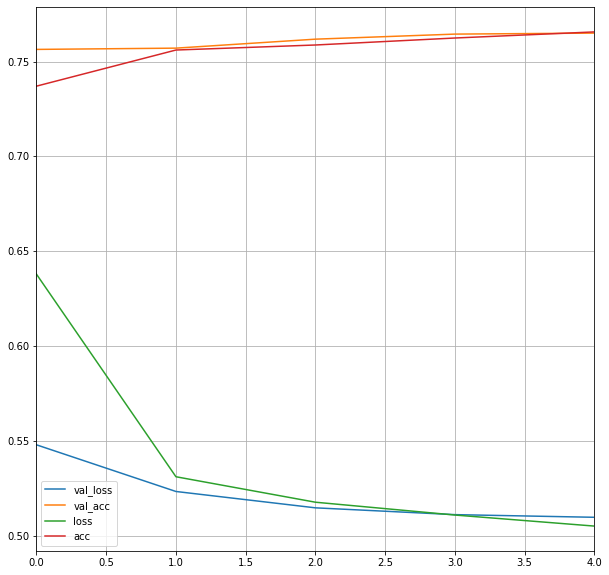

In [54]:
pd.DataFrame(history.history).plot(figsize=(10,10))
plt.grid(True)
plt.show

## Evaluate Model: elmo

In [61]:
with tf.Session() as session:
    K.set_session(session)
    session.run(tf.global_variables_initializer())  
    session.run(tf.tables_initializer())
    accuracy_test = model_elmo.evaluate(X_test, y_test, verbose=2)
    print(accuracy_test)

[1.147988013267517, 0.4886666667461395]


In [0]:
print(X_train[0:10])

["@yaeljk get to a show girl! Do whatcha gotta do! What if this is their last tour? OMG I don't wanna think about it! "
 'Ex boyfriends suck  -pete! the alien-'
 '.@SpacieStaycie which one did you like best? '
 'damn my back is hella hurtting at work '
 '@tristanwilds unfortunately my days already over '
 '@NickRich2 I did leave, but I had to come back. n wat u tryin to say? u want me to go away? '
 "@miss_pipedream oh I feel very honoured! lol. I know. I'm reading as I type. Almost finished though "
 'earned her CPR &amp; First Aid certifications! '
 'Yay, 27 people are following me! Exciting! '
 "@pworld12 I can't drink wine for a couple more days. I'm on an antibiotic  I'm gonna SMH at someone now because of it lol"]


## Confusion Matrix: elmo

In [0]:
# np.argmax Returns the indices of the maximum values along an axis. 
y_test_rounded = np.argmax(y_test, axis=1)
y_train_rounded = np.argmax(y_train, axis=1)

In [62]:
with tf.Session() as session:
    K.set_session(session)
    session.run(tf.global_variables_initializer())  
    session.run(tf.tables_initializer())
    y_pred = model_elmo.predict(X_train)
    y_pred_rounded = np.argmax(y_pred, axis=1)

KeyboardInterrupt: ignored

In [0]:
cmResults = confusion_matrix(y_train_rounded, y_pred_rounded)
accuracy = accuracy_score(y_train_rounded, y_pred_rounded)

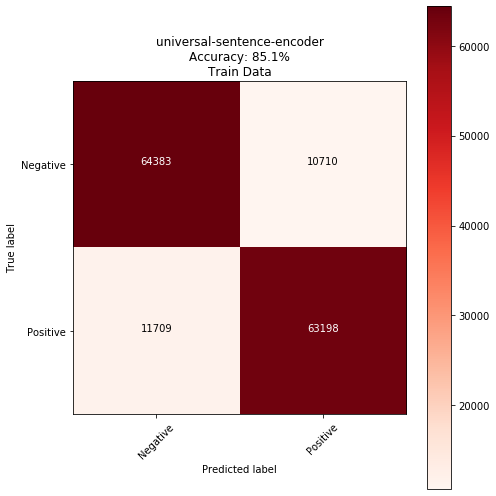

In [0]:
# Plot non-normalized confusion matrix 
class_names = ['Negative', 'Positive']
plt.figure(figsize=(7,7));
plot_confusion_matrix(cmResults, classes=class_names, 
                      title=str(MODEL)+ "\n" +"Accuracy: " + str((accuracy*100).round(1)) + "%" +"\n"+"Train Data",
                      cmap=plt.cm.Reds);

In [0]:
print(classification_report(y_train_rounded, y_pred_rounded, target_names=class_names))

              precision    recall  f1-score   support

    Negative       0.85      0.86      0.85     75093
    Positive       0.86      0.84      0.85     74907

    accuracy                           0.85    150000
   macro avg       0.85      0.85      0.85    150000
weighted avg       0.85      0.85      0.85    150000



In [0]:
with tf.Session() as session:
    K.set_session(session)
    session.run(tf.global_variables_initializer())  
    session.run(tf.tables_initializer())y_pred = model.predict(X_test)
    y_pred_rounded = np.argmax(y_pred, axis=1)
cmResults = confusion_matrix(y_test_rounded, y_pred_rounded)
accuracy = accuracy_score(y_test_rounded, y_pred_rounded)

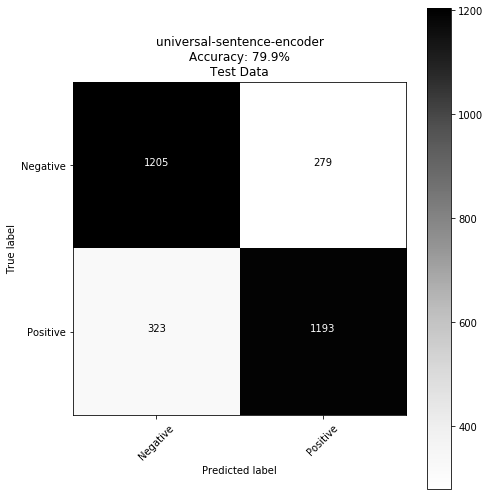

In [0]:
# Plot non-normalized confusion matrix 
plt.figure(figsize=(7,7));
plot_confusion_matrix(cmResults, classes=class_names, 
                      title=str(MODEL)+ "\n" +"Accuracy: " + str((accuracy*100).round(1)) + "%" +"\n"+"Test Data",
                      cmap=plt.cm.Greys);

In [0]:
print(classification_report(y_test_rounded, y_pred_rounded, target_names=class_names))

              precision    recall  f1-score   support

    Negative       0.79      0.81      0.80      1484
    Positive       0.81      0.79      0.80      1516

    accuracy                           0.80      3000
   macro avg       0.80      0.80      0.80      3000
weighted avg       0.80      0.80      0.80      3000



## Test the Model with some sentences

In [72]:
X_input

array(['I do not dislike cabin cruisers',
       'Montreal is a nice city in the summer!!!',
       'I have a good feeling about this team#11212',
       'The Montreal hockey team will be making the playoffs',
       'The weather in Montreal is very nice in the summer',
       'Coronet has the best lines of all day cruisers',
       'Bertram has a deep V hull and runs easily through seas.',
       "I'd really truly love going out in this weather! ",
       'Chris Craft is better looking than Limestone.',
       'Chris Craft is better looking than Limestone, but Limestone projects seaworthiness and reliability.',
       'The movie is surprising with plenty of unsettling plot twists.',
       'You should see their decadent dessert menu.',
       "Next week's gig will be right koide9!",
       'The show was not funny...', 'The dog is angry',
       "The food at the restaurant could be better'",
       'The flight is a long one',
       'It would be nice if the weather was better in Montre

In [73]:
with tf.Session() as session:
    K.set_session(session)
    session.run(tf.global_variables_initializer())  
    session.run(tf.tables_initializer())
    print(model_elmo.predict(X_input).round(0))

[[1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]]


In [0]:
print(sentiments)

[[0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]
